In [0]:
from keras import backend as K
from keras.models import Model
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, RMSprop

In this scenario:
*   Alice is the encryption algorithm
*   Bob is the decryption algorithm
*   Eve is the attacker

 We will use 16-bit messages,secret keys and ciphertexts.




In [0]:
# Set the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

# Compute the size of the message space
m_train = 2**(m_bits) #+ k_bits)

The Alice network will need to have two input vectors: the message to be encrypted, and the secret key. These get concatenated and fed to a dense layer. The signal is then passed through a sequence of four Conv1D layers to create the output.

In [0]:
ainput0 = Input(shape=(m_bits,)) # the message
ainput1 = Input(shape=(k_bits,)) # the key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('tanh')(adense1)
areshape = Reshape((m_bits + k_bits, 1,))(adense1a)
#output of the Dense layer will be 2-dimensional. This needs to be reshaped to (batch_size, m_bits + k_bits, 1) before being fed to a Conv1D layer, introducing a third dimension which would normally correspond to the number of channels 

aconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(areshape)
aconv1a = Activation('tanh')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(aconv1a)
aconv2a = Activation('tanh')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('tanh')(aconv3)
aconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('sigmoid')(aconv4)

aoutput = Flatten()(aconv4a)

alice = Model([ainput0, ainput1], aoutput, name='alice')

The Eve network will have Two dense layers acting on the inputs. The idea is to give it a better chance at decrypting the message, since it doesn’t have access to the secret key - it only sees the ciphertext.

In [0]:
einput = Input(shape=(c_bits,)) # the ciphertext 

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('tanh')(edense1)
edense2 = Dense(units=(c_bits + k_bits))(edense1a)
edense2a = Activation('tanh')(edense2)
ereshape = Reshape((c_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(ereshape)
econv1a = Activation('tanh')(econv1)
econv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(econv1a)
econv2a = Activation('tanh')(econv2)
econv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(econv2a)
econv3a = Activation('tanh')(econv3)
econv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(econv3a)
econv4a = Activation('sigmoid')(econv4)

eoutput = Flatten()(econv4a)# Eve's attempt at guessing the plaintext

eve = Model(einput, eoutput, name='eve')

Bob's network is identical to Alice’s, except input0 now represents the ciphertext instead of the plaintext.

In [0]:
binput0 = Input(shape=(c_bits,)) #message
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1b = Activation('tanh')(bdense1)
breshape = Reshape((c_bits + k_bits, 1,))(bdense1b)

bconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(breshape)
bconv1b = Activation('tanh')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(bconv1b)
bconv2b = Activation('tanh')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(bconv2b)
bconv3b = Activation('tanh')(bconv3)
bconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(bconv3b)
bconv4b = Activation('sigmoid')(bconv4)

boutput = Flatten()(bconv4b)

bob = Model([binput0, binput1], boutput, name='bob')

In [0]:
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key

The loss for Eve is just the L1 distance between ainput0 and eoutput.
Instead of doing an average, sum is taken over all the bits in the message, and its value represents the average number of bits Eve guesses incorrectly. We then take the average across the entire mini-batch with K.mean(). The minimum value of the loss is 0 (Eve guesses all the bits correctly), while the maximum is 16 (Eve is wrong about all the bits).

In [0]:
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

First, we want Bob to successfully decrypt the ciphertext.

In [0]:
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )

Alice to learn an encryption scheme which Eve can’t break. In an ideal situation, Eve should do random guessing, in which case she would correctly guess half the bits, or m_bits/2 correctly (corresponding to a loss value of 8).

In [0]:
K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

<tf.Tensor 'truediv_3:0' shape=() dtype=float32>

The square term ensures the error grows large when Eve starts to guess a few of the bits correctly. This forces Alice to adapt more rapidly to attackers, and change its encryption scheme. Overall the Alice-Bob loss will be:

In [0]:
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

As per optimizer, we use RMSprop with a default learning rate of 0.001

In [0]:
abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) #default 0.001

Finally, we create two training models with the loss functions defined earlier

In [0]:
# Build and compile the ABE model, used for training Alice-Bob networks

abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)

# Build and compile the Eve model, used for training Eve net (with Alice not there)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

Training

In [0]:
abelosses = []
boblosses = []
evelosses = []
import sys

In [0]:
n_epochs = 20
batch_size = 512
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)
while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 20 epochs with 128 batches of size 512
Epoch   0:  99% | abe: 7.836 | eve: 6.990 | bob: 7.798
Epoch   1:  99% | abe: 6.369 | eve: 3.991 | bob: 6.086
Epoch   2:  99% | abe: 4.633 | eve: 2.881 | bob: 4.190
Epoch   3:  99% | abe: 3.401 | eve: 2.155 | bob: 2.830
Epoch   4:  99% | abe: 2.445 | eve: 1.673 | bob: 1.785
Epoch   5:  99% | abe: 1.802 | eve: 1.602 | bob: 1.134
Epoch   6:  99% | abe: 1.374 | eve: 1.720 | bob: 0.732
Epoch   7:  99% | abe: 1.014 | eve: 1.864 | bob: 0.406
Epoch   8:  99% | abe: 0.766 | eve: 2.186 | bob: 0.222
Epoch   9:  99% | abe: 0.621 | eve: 2.576 | bob: 0.148
Epoch  10:  99% | abe: 0.518 | eve: 2.977 | bob: 0.109
Epoch  11:  99% | abe: 0.447 | eve: 3.301 | bob: 0.091
Epoch  12:  99% | abe: 0.391 | eve: 3.581 | bob: 0.079
Epoch  13:  99% | abe: 0.361 | eve: 3.800 | bob: 0.077
Epoch  14:  99% | abe: 0.330 | eve: 3.995 | bob: 0.071
Epoch  15:  99% | abe: 0.309 | eve: 4.141 | bob: 0.071
Epoch  16:  99% | abe: 0.301 | eve: 4.228 | bob: 0.073
Epoch  17:  9

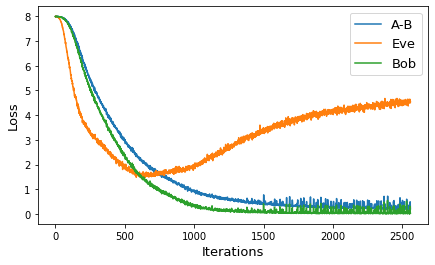

In [0]:
#Plotting
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)
plt.show()

Evaluation

In [0]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  92.16 %
Eve % correct:  0.38 %
